In [55]:
!pip install pymupdf
import fitz  # PyMuPDF
import os
import json
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

zsh:1: command not found: pip


In [56]:
def plot_page_with_bboxes(pix, page_elements, figsize=(15, 20)):
    """
    Plot a PDF page with bounding boxes for document elements.
    
    Args:
        pix: PyMuPDF pixmap object
        page_elements: List of element dictionaries with 'bbox', 'type' fields
        figsize: Tuple of (width, height) for the figure
    """
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
    
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(img)
    
    type_colors = {
        'text': 'blue',
        'figure': 'orange',
        'table': 'green',
        'title': 'red',
        'caption': 'brown',
        'section_header': 'purple',
        'page_footer': 'cyan',
        'page_header': 'magenta',
        'page_number': 'yellow',
        'footnote': 'pink',
    }
    
    # Plot bounding boxes
    for idx, element in enumerate(page_elements):
        bbox_info = element['bbox'][0]
        coord = bbox_info['coord']
        element_type = element['type']
        
        x1, y1, x2, y2 = coord
        width = x2 - x1
        height = y2 - y1
        
        color = type_colors.get(element_type, 'gray')
        
        rect = patches.Rectangle((x1, y1), width, height, 
                                 linewidth=2, edgecolor=color, 
                                 facecolor='none', alpha=0.8)
        ax.add_patch(rect)
        
        label = f"{idx}: {element_type}"
        ax.text(x1, y1 - 5, label, 
               color=color, fontsize=10, 
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7),
               verticalalignment='bottom')
    
    ax.axis('off')
    plt.tight_layout()
    plt.show()

In [57]:
# Configure paths - update the filename to render different bulletins
filename = 'treasury_bulletin_1980_01'  # Change this to render different bulletins

path_to_json = f'treasury_bulletins_parsed/jsons/{filename}.json'
path_to_pdf = f'treasury_bulletin_pdfs/{filename}.pdf'

# Page numbering: JSON uses 1-indexed page_id, PyMuPDF uses 0-indexed
# Set this to the JSON page_id you want to view
json_page_id = 23  # This is "Cash Income and Outgo" table (printed page 7)
page_to_render = json_page_id - 1  # Convert to 0-indexed for PyMuPDF

In [58]:
# Render PDF page
pdf_document = fitz.open(path_to_pdf)
page = pdf_document[page_to_render]
zoom = 200 / 75 # DPI / default_dpi
mat = fitz.Matrix(zoom, zoom)
pix = page.get_pixmap(matrix=mat, alpha=False)

In [59]:
# Get elements for page
with open(path_to_json, 'r') as f:
    json_data = json.load(f)

page_elements = [
    element for element in json_data['document']['elements']
    if any(bbox['page_id'] == json_page_id for bbox in element['bbox'])
]
print(f"Found {len(page_elements)} elements on page {json_page_id}")

Found 6 elements on page 23


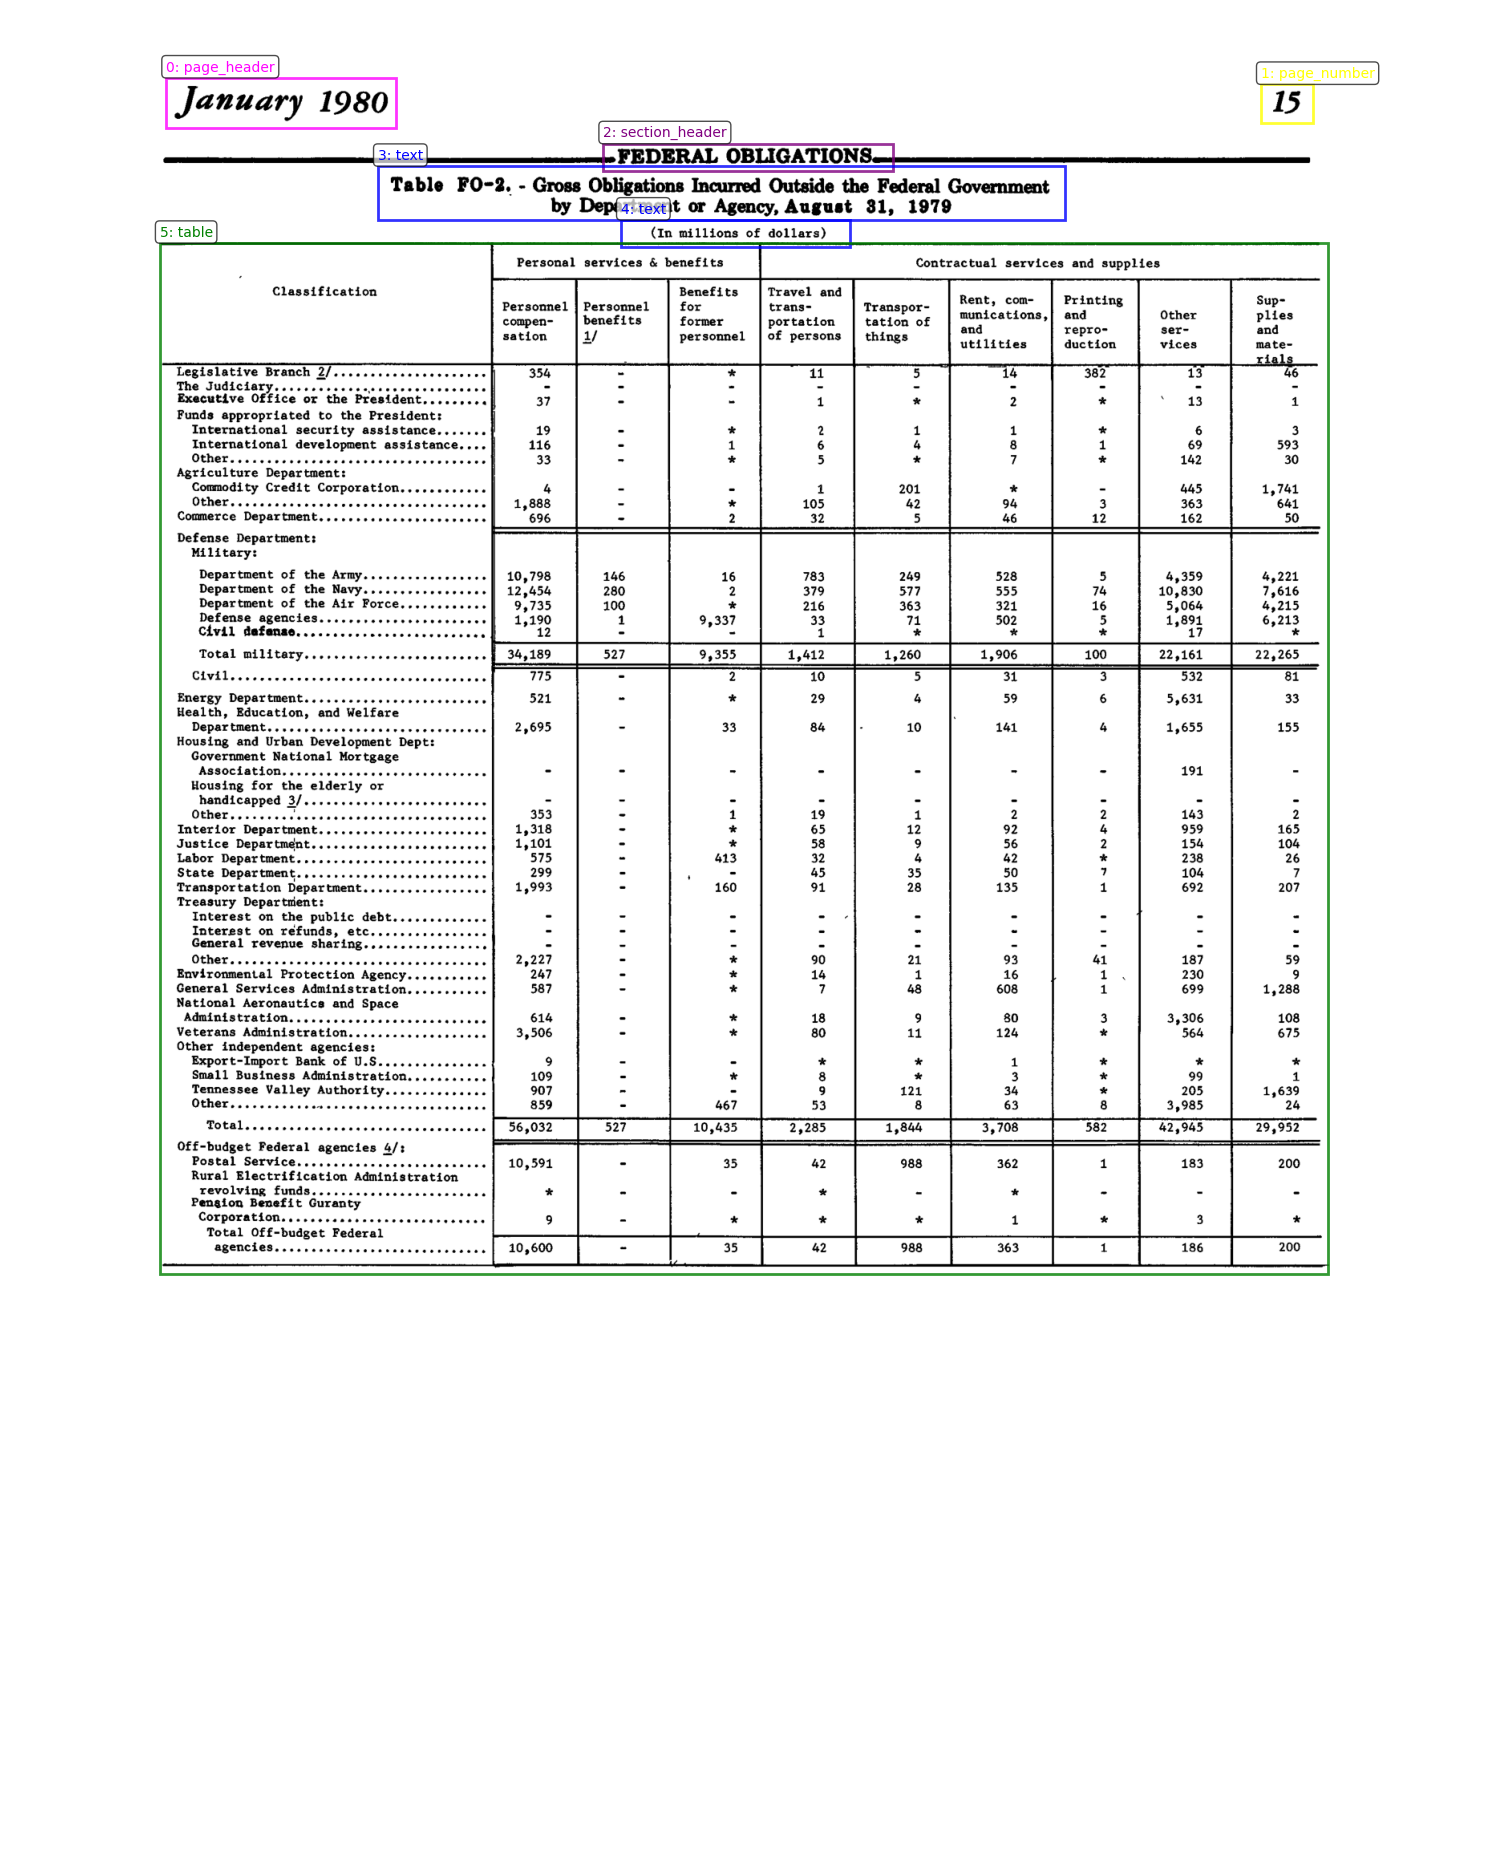

In [60]:
# Plot it
plot_page_with_bboxes(pix, page_elements)